# Milestone 1 Phase 2
Name: Judan Syamsul Hadad

Batch: FTDS-009

## 1. Introduction

Welcome. 

This notebook is made to fulfill learning goals of <u>**Full Time Data Science (FTDS) Bootcamp Batch 9**</u> by Hacktiv8 in which the author, **Judan Syamsul Hadad** also known as **Riezn**, is one of the participant.

The dataset used in this notebook can be downloaded [here](https://www.kaggle.com/blastchar/telco-customer-churn). This dataset contains information regarding customer churn in a telecommunication company and factors that might affect it.

Some of the informations provided in this dataset are as follow:
- Customer who left
- Type of services subscribed
- Customer account information
- Customer demographic

### Deployment
Deployment can be accessed at the following link:
- [Frontend](https://p2m1-front-judan.herokuapp.com/)
- [Backend](https://p2m1-backend-judan.herokuapp.com/)

### 1.1. Objective
This notebook will cover the following steps:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing:
    - Data Splitting:
        - Dataset to inference set & train-test set
        - Train-test set to train-val set & test set
        - Train-val set to train set & val set
    - Outliers Handling
    - Missing Values Handling
    - Feature Engineering (Selection, Scaling, Encoding, Pipeline Saving)
    - Tensorflow Input Pipeline
3. Model Definition:
    - Sequential API
    - Functional API
4. Model Training
5. Model Evaluation
    - Baseline model evaluation
    - Model Improvement
    - Model Saving
    - Model Explainability
6. Model Inference
7. Conclusion

### 1.2. Problem Statement
Which factors might affect customer churn and how does the model look like?

## 2. Import Libraries

In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import tensorflow as tf
import random
from dython.nominal import associations
warnings.filterwarnings('ignore')

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

#models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization

#validation and evaluation
import dalex as dx
from sklearn.metrics import classification_report

## 3. Data Loading

Disable eager execution to manage compatibility issues with other libraries.

In [25]:
# tf.compat.v1.disable_eager_execution() #required for running SHAP due to compatibility issue, this will backtrack to the previous version of tensorflow and some warnings might pop out

Define random state and seed for the whole notebook.

In [26]:
random_state = 34
random.seed = random_state
np.random.seed = random_state
tf.random.set_seed(random_state)

Set pandas to display all columns.

In [27]:
pd.set_option('display.max_columns', None)

Load dataset.

In [28]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Copy dataset.

In [29]:
df = data.copy()

Check the top 5 rows of the dataset.

In [30]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Dataset is loaded properly.

Check dataset properties.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The dataset contains 7043 entries with 21 columns. There are categorical and numerical features in the dataset.

Check unique values in categorical features.

In [32]:
df.select_dtypes(include=['object']).nunique()

customerID          7043
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
Churn                  2
dtype: int64

- `customerID` is the primary key of the dataset based on the number of unique values in the column being the same as total entries
- Some columns have more than 2 unique values, further check is needed whether these unique values are in actual missing values or actual categories
- `TotalCharges` have high cardinality which is very suspicious. It might be a numerical column which contains a lot of missing values and then treated as `object` class

Check for duplicated in dataset.

In [33]:
df.duplicated().sum()

0

There is no duplicated entry in the dataset.

Check the descriptive statistics of the dataset.

In [34]:
df.describe(include='all').T.sort_values(by='mean', ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here are some interesting findings:
- `SeniorCitizen` is likely to be a categorical data based on the range of values with most entries not being senior citizens
- `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` have three categories despite the most frequent value being `No` which means one of the other value is `Yes`
- `TotalCharges` most frequent value is empty string which might reinforce the previous assumption that the column is in actual numerical

Let's check `TotalCharges` first.

In [35]:
df['TotalCharges'].value_counts().reset_index()

,index,TotalCharges
0,,11
1,20.2,11
2,19.75,9
3,20.05,8
4,19.9,8
...,...,...
6526,6849.4,1
6527,692.35,1
6528,130.15,1
6529,3211.9,1


Since our assumption is confirmed, change the missing value to NaN and the data type of `TotalCharges` to `float`.

In [36]:
df['TotalCharges'].replace({' ':np.nan}, inplace=True)
df['TotalCharges'].isnull().sum()

11

In [37]:
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].dtype

dtype('float64')

Define each column group.

In [38]:
num_cols = df.drop(columns=['customerID', 'SeniorCitizen']).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.drop(columns=['customerID', 'TotalCharges', 'Churn']).select_dtypes(include=['object']).columns.tolist() + ['SeniorCitizen']
print(num_cols)
print(cat_cols)

['tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


Recheck dataset properties.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


All changes are accounted for. We will check the multicategorical features in EDA.

## 4. Exploratory Data Analysis (EDA)

Let's check the ratio of `Churn` first.

In [40]:
import plotly.express as px

In [42]:
df['Churn-num'] = df['Churn'].map({'Yes':1, 'No':0})

In [54]:
pie = df['Churn'].reset_index().groupby('Churn').count().reset_index()

In [55]:
pie

,Churn,index
0,No,5174
1,Yes,1869


In [57]:
px.pie(pie, values='index', names='Churn', title='Churn', width=400, height=400)

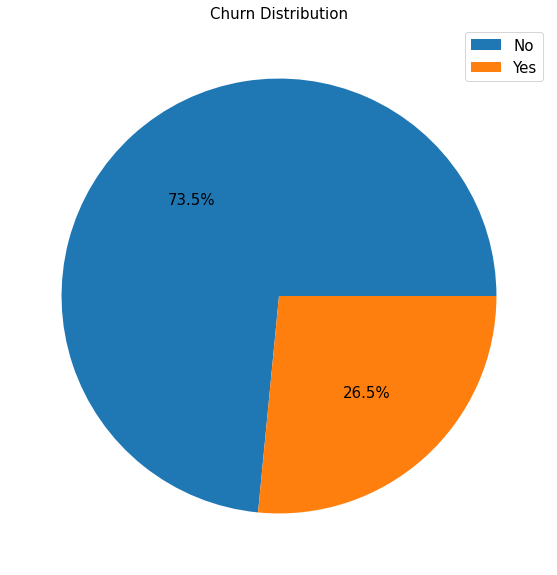

In [64]:
plt.figure(facecolor='white',figsize=(10,10))
plt.pie(df['Churn'].value_counts(), autopct='%1.1f%%', textprops={'fontsize': 15})
plt.title('Churn Distribution', fontsize=15)
plt.legend(labels=['No', 'Yes'], fontsize=15)
plt.show()

<AxesSubplot:>

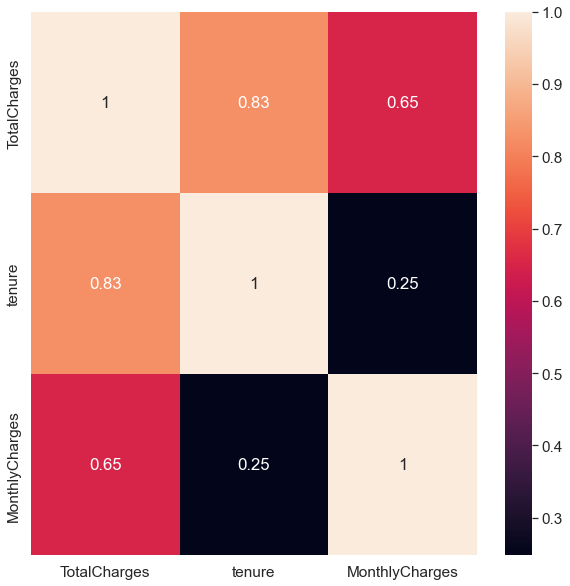

In [113]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4)
sns.heatmap(df[num_cols].corr(), annot=True)

It's a bit imbalanced with ratio roughly 3:1 between customers who left and customers who stayed.

EDA will be divided based on the following:
- Univariate and bivariate analysis between numerical features
- Relationship between numerical features and target
- Relationship between categorical features and target
- Correlation between all features and target

### 4.1. Univariate and Bivariate Analysis Between Numerical Features

Check the distribution and correlation between numerical features using pairplot.

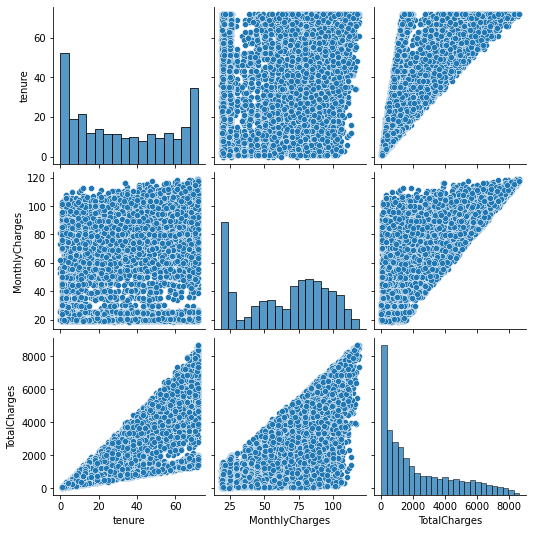

In [65]:
sns.pairplot(df[num_cols])
plt.show()

Univariate analysis based on the histograms:
- `tenure`'s distribution does not seem to follow any general pattern/distribution type
- `MonthlyCharges`'s distribution looks a little bit like normal distribution
- `TotalCharges` is most likely skewed to the right

Bivariate analysis based on the scatter plots:
- `tenure`-`MonthlyCharges` do not indicate any correlation
- `tenure`-`TotalCharges` and `MonthlyCharges`-`TotalCharges` have a similar shape. Both likely have positive correlations that are also influenced by other features as the variances in `TotalCharges` increase along with both `tenure` and `MonthlyCharges`

### 4.2. Relationship Between Numerical Features and Target

To find out the relationships between numerical features and target, we will use barplots with means of each target value.

Make a function to plot all numerical features against target.

In [66]:
def barplot_num_target(dataframe, num_features, target):
    '''
    take input dataframe and plot each feature in num_features from dataframe numerical columns against target column in dataframe
    '''

    fig, ax = plt.subplots(ncols=len(num_features), figsize=(len(num_features)*7, 5))
    for i, feature in enumerate(num_features):
        sns.barplot(x=target, y=feature, data=dataframe, label=target, ax=ax[i])
    plt.show()

Plot numerical columns against `Churn` using the function.

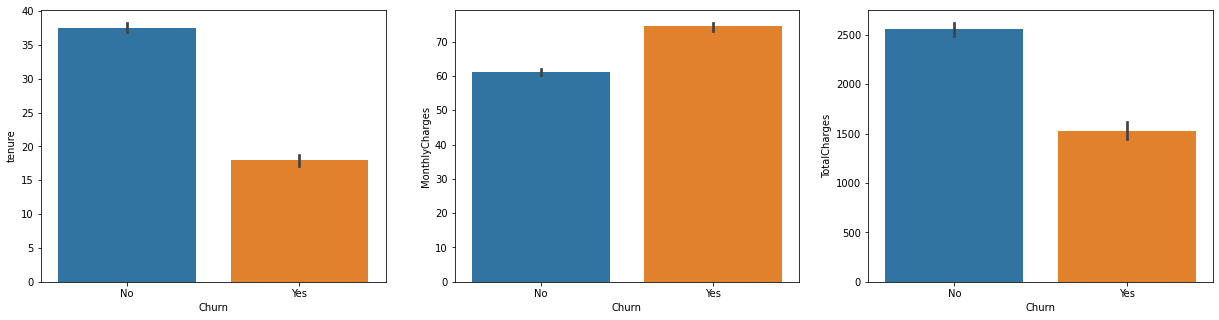

In [67]:
barplot_num_target(df, num_cols, 'Churn')

Here are some things that can be inferred from the barplots:
- Retained customers have almost double `tenure` compared to customers who left
- Retained customers have slightly lower `MonthlyCharges` compared to customers who left
- Retained customers have slightly higher `TotalCharges` compared to customers who left, this is most likely due to retained customers having longer `tenure`

### 4.3. Relationship Between Categorical Features and Target

We will use countplot to see the difference between each unique value and barplot to see the tendency of each unique value to `Churn` using the following function:

First define a new column that translates `Churn` to numerical value with `Yes` as 1 and `No` as 0.

In [89]:
df['Churn-num'] = df['Churn'].map({'Yes':1, 'No':0})

Define the function.

In [68]:
def cat_plot(dataframe, feature, target):
    '''
    general function to plot categorical features value counts and tendency of unique value to Churn
    '''

    #dataframe for value count
    feature_count = dataframe[feature] \
        .reset_index(drop=False) \
        .groupby(feature) \
        .count() \
        .rename({'index':'count'},axis=1) \
        .reset_index()
    
    #dataframe for tendency to churn
    feature_chance = df[[feature, target]] \
        .groupby(feature) \
        .mean() \
        .reset_index()

    fig,ax = plt.subplots(1,2, figsize=(10,5))

    #plot value count
    ax[0] = plt.subplot(1,2,1)
    ax[0] = sns.barplot(x=feature, y='count',data=feature_count, ax=ax[0])
    ax[0] = plt.xlabel(feature)
    ax[0] = plt.ylabel(feature + ' count')
    ax[0] = plt.xticks(rotation=15)
    ax[0] = plt.title('{feature} Count'.format(feature=feature))

    #plot tendency to churn
    ax[1] = plt.subplot(1,2,2)
    ax[1] = sns.barplot(x=feature, y=target, data=feature_chance, ax=ax[1])
    ax[1] = plt.title('Tendency of {Feature} to Churn'.format(Feature=feature))
    ax[1] = plt.ylabel('Chance to Churn')
    ax[1] = plt.xlabel(feature)
    ax[1] = plt.xticks(rotation=15)
    plt.show()

Plot for every categorical features. For ease of analysis, the summary of each plot will be defined in:
- Highest count
- Highest tendency to `Churn`

Some plots may have reasoning behind them, some may not.

The following conditions will apply when concluding the relationship between categorical features and target at each plot:
- The term **slightly** will be used in the case where author find the difference is insignificant and thus assummed to have the same count/tendency
- If all the unique values have **slight** difference in tendency, then it is assumed that the relationship between the categorical feature and target is insignificant

#### `gender`

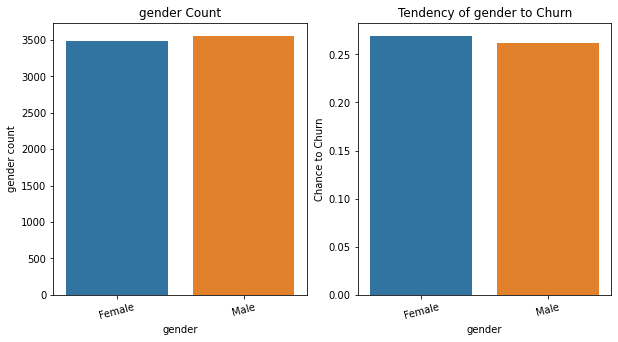

In [91]:
cat_plot(df, cat_cols[0], 'Churn-num')

- `male` customers has **slightly** higher count
- Female customers have **slightly** higher tendency to `Churn`
- `gender` will very likely have no effect on customer's decision to `Churn`

#### `Partner`

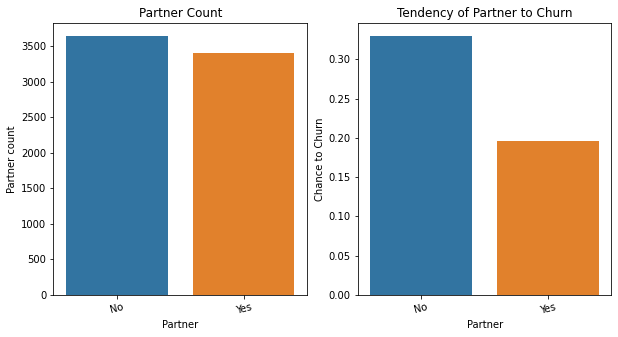

In [92]:
cat_plot(df, cat_cols[1], 'Churn-num')

- Customers without `Partner` has **slightly** higher count
- Customers without `Partner` has higher tendency to `Churn`
- `Partner` will very likely have effect on customer's decision to `Churn`
- Customers without `Partner` normally have less things to think of thus they can ascertain whether a service that they subscribed to is worth the fee or not

#### `Dependents`

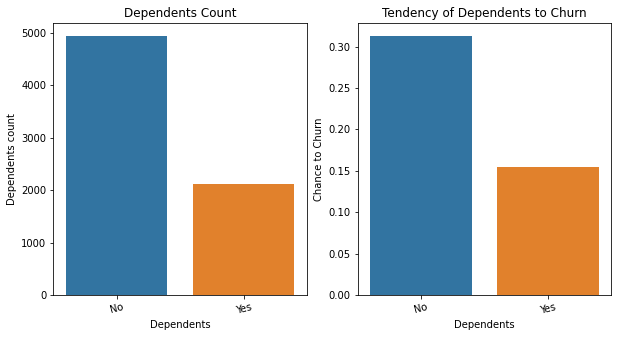

In [93]:
cat_plot(df, cat_cols[2], 'Churn-num')

- Customers without `Dependents` has higher count
- Customers without `Dependents` has higher tendency to `Churn`
- `Dependents` will very likely have effect on customer's decision to `Churn`
- Just like `Partners`, customers without `Dependents` will probably take more consideration to service that they subscribed to

#### `PhoneService`

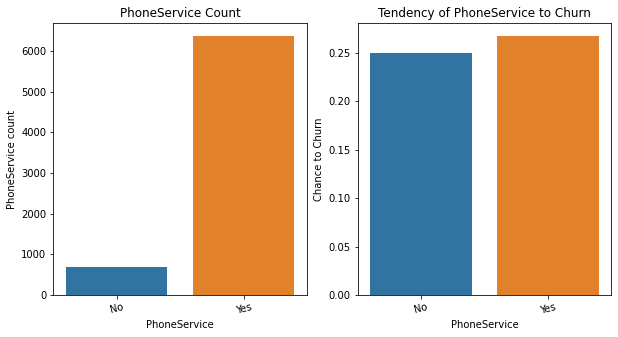

In [94]:
cat_plot(df, cat_cols[3], 'Churn-num')

- Customers with `PhoneService` has significantly higher count
- Customers with `PhoneService` has **slightly** higher tendency to `Churn`
- `PhoneService` will very likely have no effect on customer's decision to `Churn`

#### `MultipleLines`

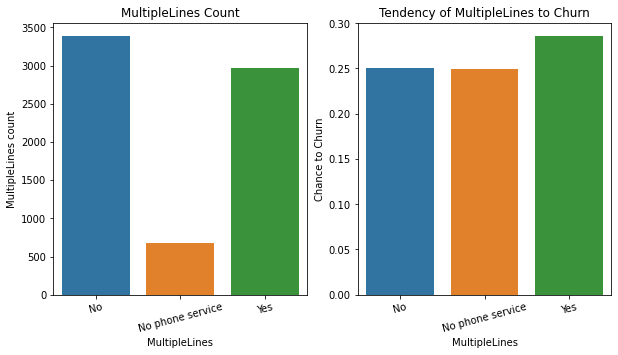

In [95]:
cat_plot(df, cat_cols[4], 'Churn-num')

- Customers with and without `MultipleLines` have significantly higher count
- Customers with `MultipleLines` has **slightly** higher tendency to `Churn`
- `MultipleLines` will very likely have no effect on customer's decision to `Churn`

#### `InternetService`

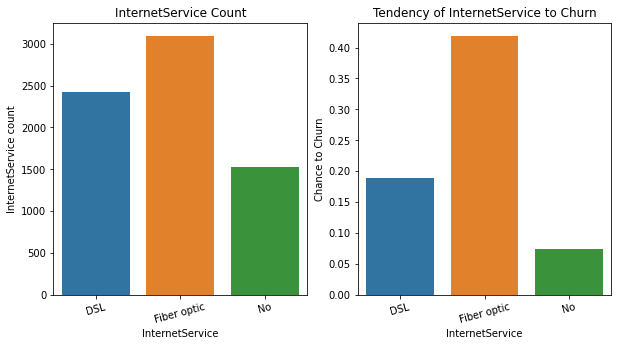

In [96]:
cat_plot(df, cat_cols[5], 'Churn-num')

- Customers with `Fiber optic` has the highest count followed by `DSL`
- Customers with `Fiber optic` has significantly higher tendency to `Churn`
- `InternetService` will very likely have effect on customer's decision to `Churn`
- This is a conjecture from the author, but it is very likely that the `Fiber optic` service that is offered by the company doesn't live up to the monthly fee that the customer pays

#### `OnlineSecurity`

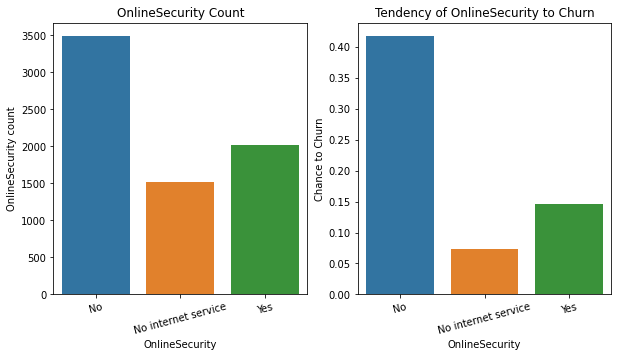

In [97]:
cat_plot(df, cat_cols[6], 'Churn-num')

- Customers without `OnlineSecurity` have the highest count followed by customers with `OnlineSecurity`
- Customers without `OnlineSecurity` has significantly higher tendency to `Churn`
- `OnlineSecurity` will very likely have effect on customer's decision to `Churn`
- Other providers might offer the same service but included this feature for the same price range

#### `OnlineBackup`

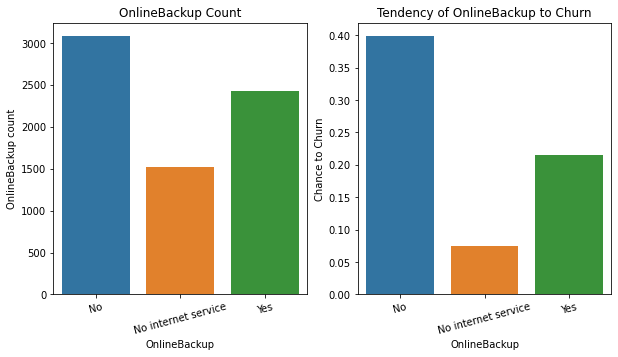

In [98]:
cat_plot(df, cat_cols[7], 'Churn-num')

- Customers without `OnlineBackup` have the highest count followed by customers with `OnlineBackup`
- Customers without `OnlineBackup` has significantly higher tendency to `Churn`
- `OnlineBackup` will very likely have effect on customer's decision to `Churn`
- Other providers might offer the same service but included this feature for the same price range

#### `DeviceProtection`

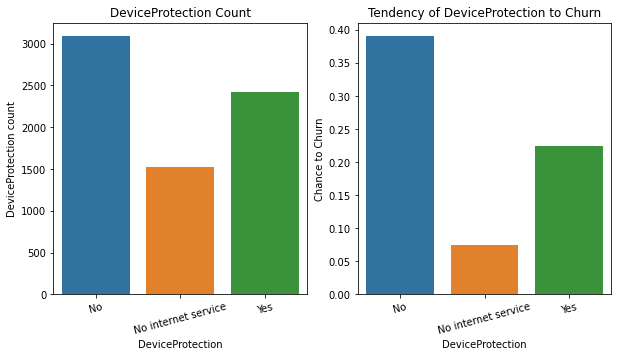

In [99]:
cat_plot(df, cat_cols[8], 'Churn-num')

- Customers without `DeviceProtection` have the highest count followed by customers with `DeviceProtection`
- Customers without `DeviceProtection` has significantly higher tendency to `Churn`
- `DeviceProtection` will very likely have effect on customer's decision to `Churn`
- Other providers might offer the same service but included this feature for the same price range

#### `TechSupport`

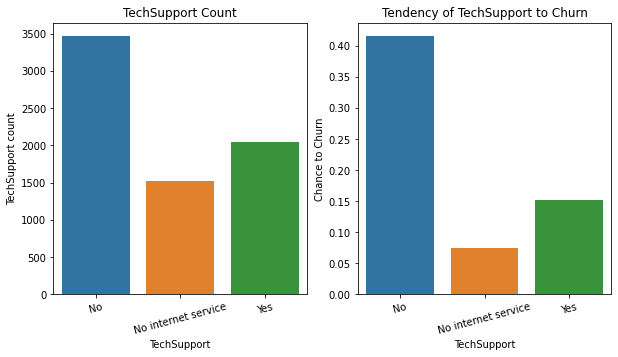

In [100]:
cat_plot(df, cat_cols[9], 'Churn-num')

- Customers without `TechSupport` have the highest count followed by customers with `TechSupport`
- Customers without `TechSupport` has significantly higher tendency to `Churn`
- `TechSupport` will very likely have effect on customer's decision to `Churn`
- Other providers might offer the same service but included this feature for the same price range

#### `StreamingTV`

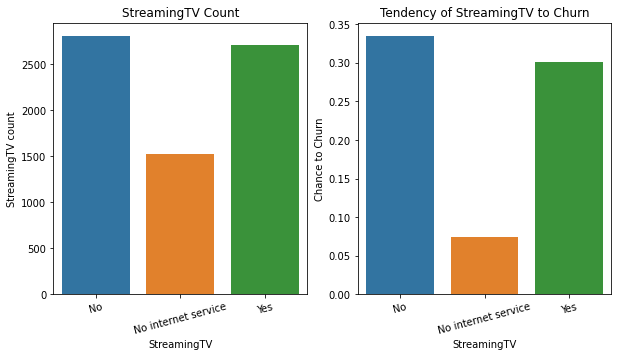

In [101]:
cat_plot(df, cat_cols[10], 'Churn-num')

- Customers without `StreamingTV` have the highest count followed by customers with `StreamingTV` albeit only **slight** difference
- Customers with and without `StreamingTV` has significantly higher tendency to `Churn`
- `StreamingTV` will very likely have effect on customer's decision to `Churn`
- This feature may not even be relevant to the customer and even if it does, the content may not be what the customer is looking for thus the only significant difference is for customer without internet service

#### `StreamingMovies`

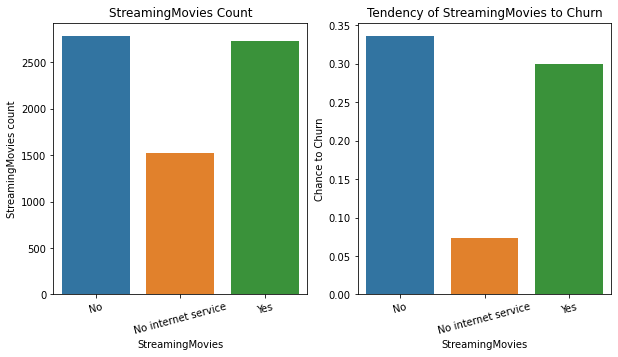

In [102]:
cat_plot(df, cat_cols[11], 'Churn-num')

- Customers without `StreamingMovies` have the highest count followed by customers with `StreamingMovies` albeit only **slight** difference
- Customers with and without `StreamingMovies` has significantly higher tendency to `Churn`
- `StreamingMovies` will very likely have effect on customer's decision to `Churn`
- This feature has the same reasoning as `StreamingTV`, the service may not be relevant to the customer

#### `Contract`

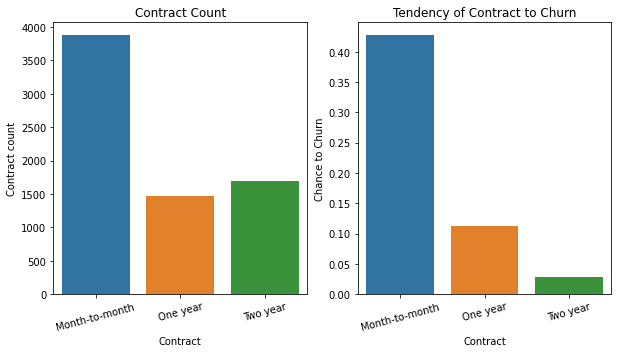

In [103]:
cat_plot(df, cat_cols[12], 'Churn-num')

- Customers with `Month-to-month` have the highest count
- Customers with `Month-to-month` has significantly higher tendency to `Churn`
- `Contract` will very likely have effect on customer's decision to `Churn`
- Customers with `Month-to-month` can easily cut the contract because of flexibility without being bound by penalty from the contract thus higher tendency to `Churn`

#### `PaperlessBilling`

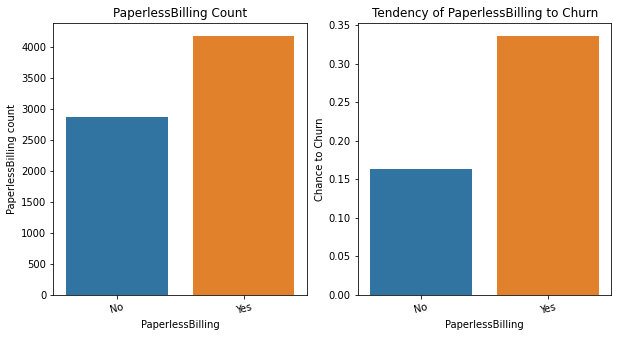

In [104]:
cat_plot(df, cat_cols[13], 'Churn-num')

- Customers with `PaperlessBilling` have the highest count
- Customers with `PaperlessBilling` has significantly higher tendency to `Churn`
- `PaperlessBilling` will very likely have effect on customer's decision to `Churn`

#### `PaymentMethod`

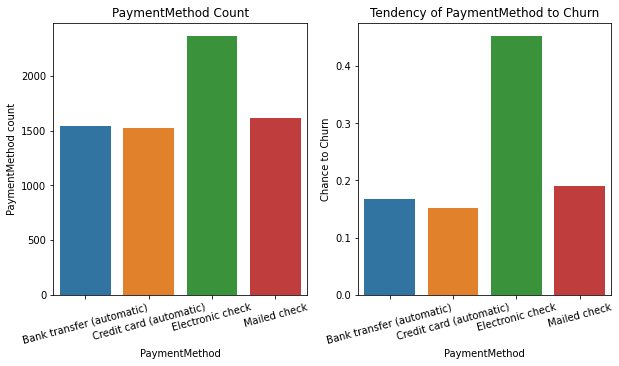

In [105]:
cat_plot(df, cat_cols[14], 'Churn-num')

- Customers with `Electronic check` have the highest count
- Customers with `Electronic check` has significantly higher tendency to `Churn`
- `PaymentMethod` will very likely have effect on customer's decision to `Churn`
- This feature may correlate with ease of payment for the customer with `Electronic check` being the easiest to control while with the `automatic` ones, they may have been billed before they can cancel the subscription and the `mailed check` ones may arrive late and thus the customer need to pay first before canceling the service

#### `SeniorCitizen`

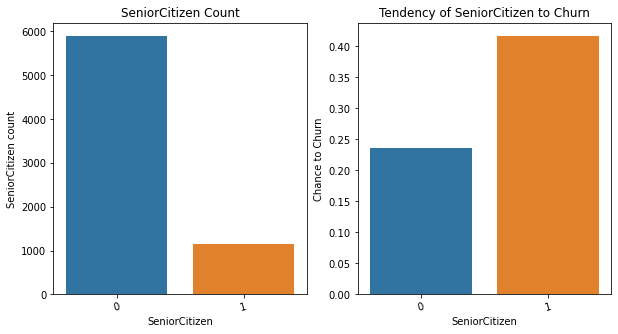

In [106]:
cat_plot(df, cat_cols[15], 'Churn-num')

- `Non senior citizen` have the highest count
- `Senior citizen` has significantly higher tendency to `Churn`
- `SeniorCitizen` will very likely have effect on customer's decision to `Churn`
- `SeniorCitizen` may have less use for the service and thus higher tendency to `Churn`

#### Summary

These are the features that very likely won't affect the decision to `Churn`:
- `gender`
- `PhoneService`
- `MultipleLines`


The following are the features that may partially (some unique values have the same responses to decision) affect the decision to `Churn`:
- `StreamingTV`
- `StreamingMovies`
- `PaymentMethod`

Lastly these are the features that will fully affect the decision to `Churn`:
- `Partner`
- `Dependents`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `Contract`
- `PaperlessBilling`
- `SeniorCitizen`

### 4.4. Categorical Features Against Target

Lastly, we will check the correlation between all features both numerical and categorical.

The library used to check the correlation is `Dython`. Each relationship is calculated with the following method:
- Numerical-Numerical: `Pearson's R`
- Numerical-Categorical: `Correlation Ratio`
- Categorical-Categorical: `Cramer's V`

Strong correlation will be defined as having a value greater than 0.7 or less than -0.7. See the heatmap below.

In [98]:
exc = ['Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'gender', 'PhoneService', 'MultipleLines']

In [ ]:
inc = [x for x in df.colu]

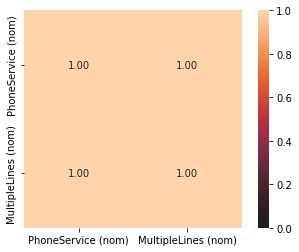

In [96]:
ax = associations(df[['PhoneService', 'MultipleLines']], numerical_columns=num_cols, nan_strategy='drop_samples', fmt='.2f',annot=True, clustering=True, mark_columns=True)

In [123]:
exc2 = ['gender', 'Partner', 'Dependents', 'SeniorCitizen', 'Contract', 'PaperlessBilling', 'PaymentMethod']

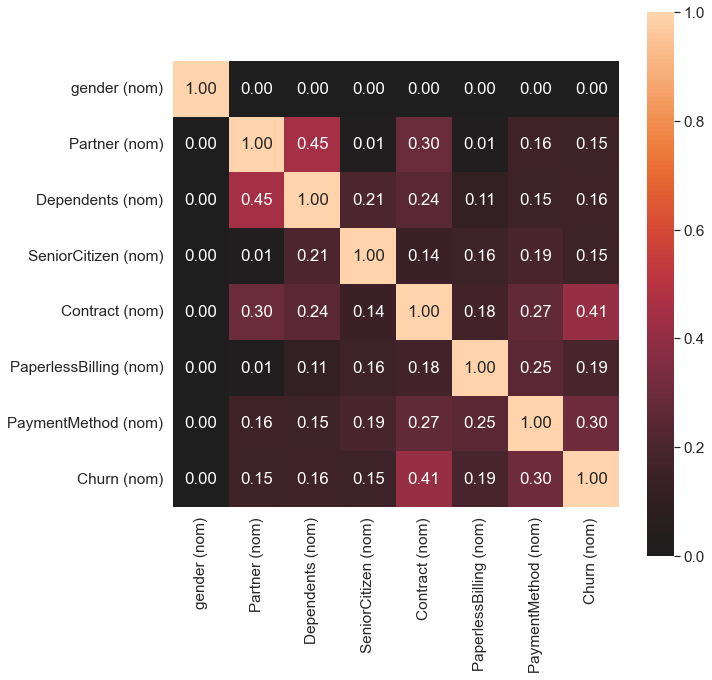

In [125]:
ax = associations(df[exc2+['Churn']], numerical_columns=num_cols, nan_strategy='drop_samples', fmt='.2f',annot=True, mark_columns=True, figsize=(10,10))

In [104]:
num_cols = ['TotalCharges', 'tenure', 'MonthlyCharges']

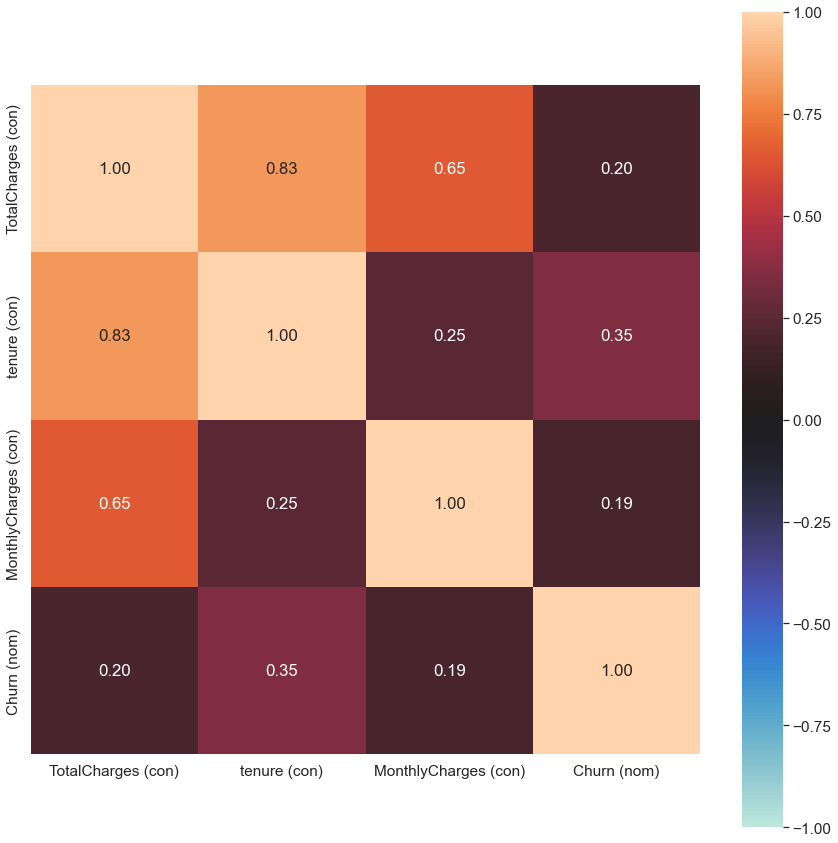

In [114]:
ax = associations(df[num_cols+['Churn']], numerical_columns=num_cols, nan_strategy='drop_samples', fmt='.2f',annot=True, mark_columns=True, figsize=(15,15))

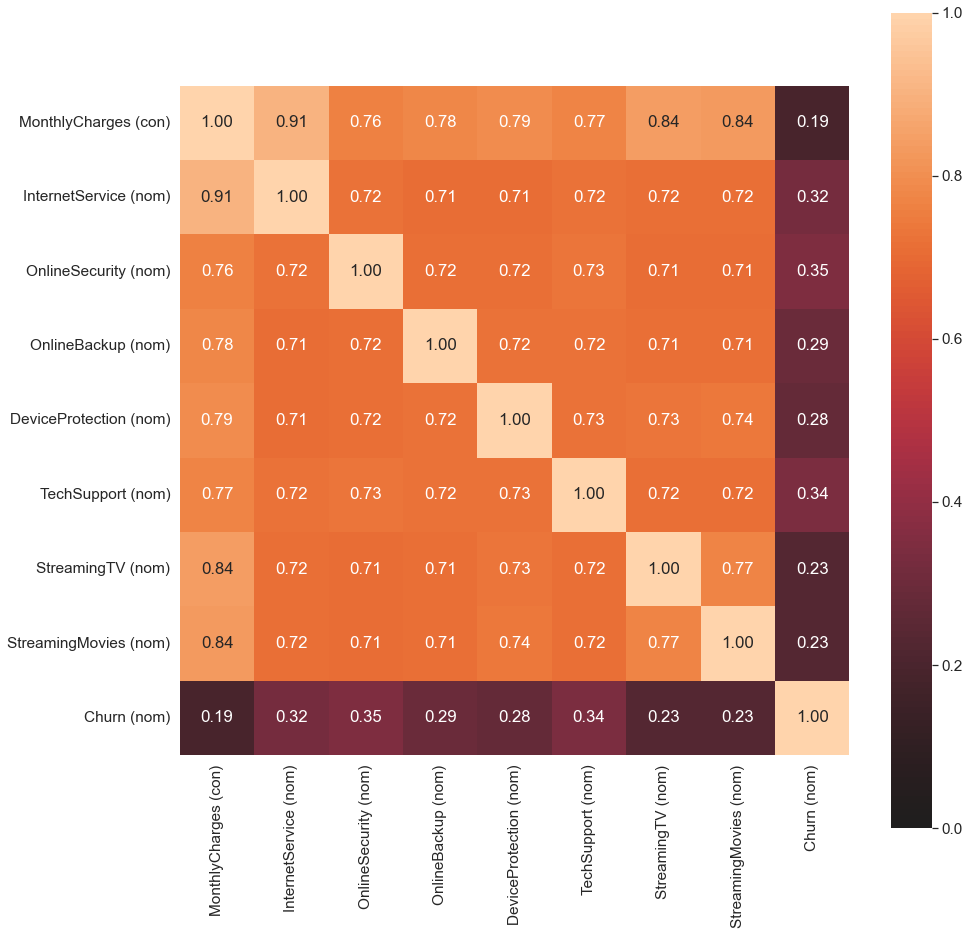

In [115]:
ax = associations(df[['MonthlyCharges']+cat_cols+['Churn']].drop(columns=exc), numerical_columns=num_cols, nan_strategy='drop_samples', fmt='.2f',annot=True, mark_columns=True, figsize=(15,15))

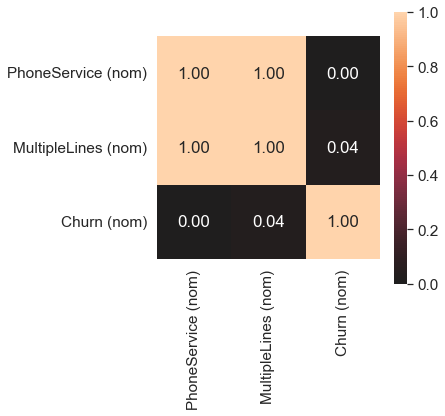

In [117]:
ax = associations(df[['PhoneService','MultipleLines','Churn']], numerical_columns=num_cols, nan_strategy='drop_samples', fmt='.2f',annot=True, mark_columns=True, figsize=(5,5))

Overall there should be five kinds of correlation:
- num-num
- num-target
- cat-cat
- cat-target
- cat-num

Since we have already explored num-num, num-target, and cat-target, we will only explore cat-cat and cat-num correlation. 

- `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `Contract`, `PaperlessBilling`, `PaymentMethod` do not have any strong correlations with other categorical features
- `tenure` and `TotalCharges` only have strong correlation with each other and can be represented with only one feature
- `PhoneService` and `MultipleLines` can be considered the same and can be represented with only one feature
- `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `StreamingTV`, `StreamingMovies`, and `MonthlyCharges` have strong correlation with each others and can be represented with only one feature

Let's check the ones with strong correlations. Since we have explored num-num correlation earlier, we will see how the correlation works between `PhoneService`-`MultipleLines` and `InternetService`-`OnlineSecurity`-`OnlineBackup`-`DeviceProtection`-`StreamingTV`-`StreamingMovies`-`MonthlyCharges`.

#### `PhoneService`-`MultipleLines`

Let's use barplot to check the data counts grouped by `PhoneService` and `MultipleLines`.

Define a general function for plotting categorical to categorical.

In [118]:
def cat_cat_plot(dataframe, cat_a, cat_b):
    '''
    generate barplot to map categorical features to each other
    '''

    df_pm = dataframe[[cat_a, cat_b]].reset_index().groupby([cat_a, cat_b]).count().reset_index()

    plt.figure(figsize=(10,5))
    sns.barplot(y='index', x=cat_a, hue=cat_b, data=df_pm)
    plt.ylabel('Count')

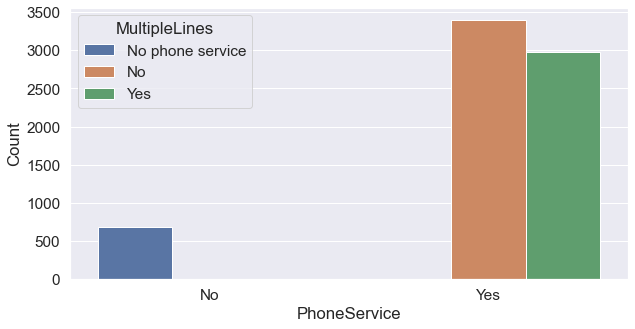

In [120]:
cat_cat_plot(df, 'PhoneService', 'MultipleLines')

From the barplot we found that the count is entirely separated by customers' subscription to `PhoneService`. If they don't subscribe to `PhoneService`, then the outcome in `MultipleLines` will definitely result in `No phone service`, but if they do, then it will strictly be limited to `Yes` if they subscribe to `MultipleLines` and `No` if they don't.

#### `InternetService`-`OnlineSecurity`-`OnlineBackup`-`DeviceProtection`-`StreamingTV`-`StreamingMovies`-`MonthlyCharges`

For these features we will see the correlation using stripplot with `MonthlyCharges` as the y-axis.

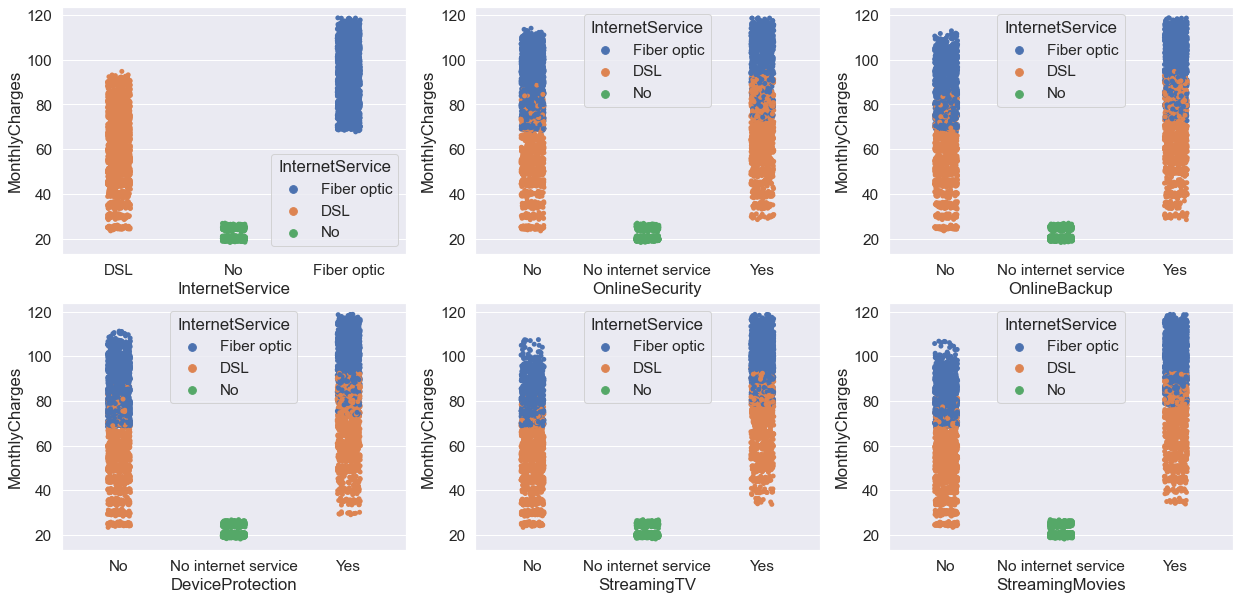

In [121]:
#define column and initialize index
cat_num_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']
j = 0

#loop for each feature
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21,10))
for i, col in enumerate(cat_num_cols):
    if i == 3:
        j+=1

    if col == 'InternetService':
        order=['DSL','No','Fiber optic']
    else:
        order=None

    sns.stripplot(x=col, y='MonthlyCharges', data=df.sort_values(by=col), order=order, hue='InternetService', hue_order=['Fiber optic', 'DSL', 'No'],ax=ax[j, i%3])

plt.show()

In [122]:
exc

['Partner',
 'Dependents',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'gender',
 'PhoneService',
 'MultipleLines']

From the stripplots we can see that all six categorical features have the same tendency in which if the customer subscribes to a service, the `MonthlyCharges` will be the highest, followed by customer who doesn't, and at the lowest the customer who doesn't use internet service at all.

Another take is we know in general that `Fiber optic` will always have higher `MonthlyCharges`.

The key takeaway is from all these features we can just keep `MonthlyCharges` and `InternetService` to represent the rest.

Later we can reanalyze the correlation using train set, but some reference can be taken from EDA in which the followings are the features that probably will be retained for fitting the model:
- `gender`
- `SeniorCitizen`
- `Partner`
- `Dependents`
- `Contract`
- `PaperlessBilling`
- `PaymentMethod`
- `tenure`, chosen instead of `TotalCharges` because of lower dependency towards `MonthlyCharges`
- `MultipleLines`, chosen so the model can learn better with more choices
- `MonthlyCharges`
- `InternetService`

## 5. Data Preprocessing

We will preprocess the data before using it to train the model.

### 5.1. Data Splitting

Define X and y. Since the output will be in binary, we will use `Churn-num` as y.

In [111]:
y = df['Churn-num']
X = df[num_cols+cat_cols]

Split the dataset into train, validation, and test set.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state,stratify=y)

In [113]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state,stratify=y_train)

Split into numerical and categorical features.

In [114]:
X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

### 5.2. Outliers Handling

Make a function to detect outliers.

In [115]:
#detect outliers for normal distribution
def find_normal_boundaries(dataframe, variable):
    upper_boundary = dataframe[variable].mean() + 3 * dataframe[variable].std()
    lower_boundary = dataframe[variable].mean() - 3 * dataframe[variable].std()
    return upper_boundary, lower_boundary

#detect outliers for skewed distribution
def find_skewed_boundaries(dataframe, variable):
    Q1 = dataframe[variable].quantile(0.25)
    Q3 = dataframe[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR
    lower_boundary = Q1 - 1.5 * IQR
    return upper_boundary, lower_boundary

def outliersum(dataframe):
    #variables for summary
    distribution = []
    skewness = []
    upper_limit = []
    lower_limit = []
    outliers_percent = []
    mean = []
    max = []
    min = []

    #loop to create summary of outliers
    for column in dataframe.columns:

        #cek skewness
        col_skewness = dataframe[column].skew()

        #conditional based on skewnewss
        if (col_skewness >= -0.5) & (col_skewness <= 0.5):
            col_distribution = 'Normal'
            col_upper_limit, col_lower_limit = find_normal_boundaries(dataframe,column)      
        else:
            col_distribution = 'Skewed'
            col_upper_limit, col_lower_limit = find_skewed_boundaries(dataframe,column)
        
        #check mean, min, max, and percentage of outliers
        col_max = dataframe[column].max()
        col_min = dataframe[column].min()
        col_outliers_percent = (len(dataframe[dataframe[column] > col_upper_limit]) +  \
                                len(dataframe[dataframe[column] < col_lower_limit])) / \
                                len(dataframe) * 100
        col_mean = dataframe[column].mean()

        #update summary for each loop
        distribution.append(col_distribution)
        skewness.append(col_skewness)
        upper_limit.append(col_upper_limit)
        max.append(col_max)
        min.append(col_min)
        lower_limit.append(col_lower_limit)
        outliers_percent.append(col_outliers_percent)
        mean.append(col_mean)

    #df summary
    outliers_summary = {'distribution_type':distribution,
                        'skewnewss':skewness,
                        'mean': mean,
                        'min':min ,
                        'lower_limit':lower_limit,
                        'upper_limit':upper_limit,
                        'max':max,
                        'outliers_percent':outliers_percent}
    outliers_summary = pd.DataFrame(outliers_summary,index=dataframe.columns)
    outliers_summary = round(outliers_summary.sort_values(by='outliers_percent',ascending=False),2)
    return outliers_summary

Check for outliers.

In [116]:
outsum = outliersum(X_train_num)
outsum

,distribution_type,skewnewss,mean,min,lower_limit,upper_limit,max,outliers_percent
tenure,Normal,0.25,32.24,0.00,-41.64,106.11,72.00,0.0
MonthlyCharges,Normal,-0.21,64.57,18.25,-25.69,154.83,118.75,0.0
TotalCharges,Skewed,0.98,2277.71,18.80,-4701.86,8874.24,8684.80,0.0


There are no outliers detected.

### 5.4. Missing Values Detection

We know from data loading that we have some missing values.

In [117]:
X_train_num.isnull().sum().sum()

7

Check the missing values.

In [118]:
X_train_num[X_train_num['TotalCharges'].isnull()==True]

,tenure,MonthlyCharges,TotalCharges
1082,0,25.75,NaN
4380,0,20.00,NaN
936,0,80.85,NaN
6754,0,61.90,NaN
5218,0,19.70,NaN
3331,0,19.85,NaN
1340,0,56.05,NaN


All the missing values have 0 tenure which might translate to customers that stop their contract before reaching one month. Thus, we can assume that the `TotalCharges` should be equal to their `MonthlyCharges`.

In [119]:
X_train_num['TotalCharges'].fillna(X_train_num['MonthlyCharges'], inplace=True)

### 5.5. Feature Engineering

#### 5.5.1. Feature Selection

Recreate heatmap using train set.

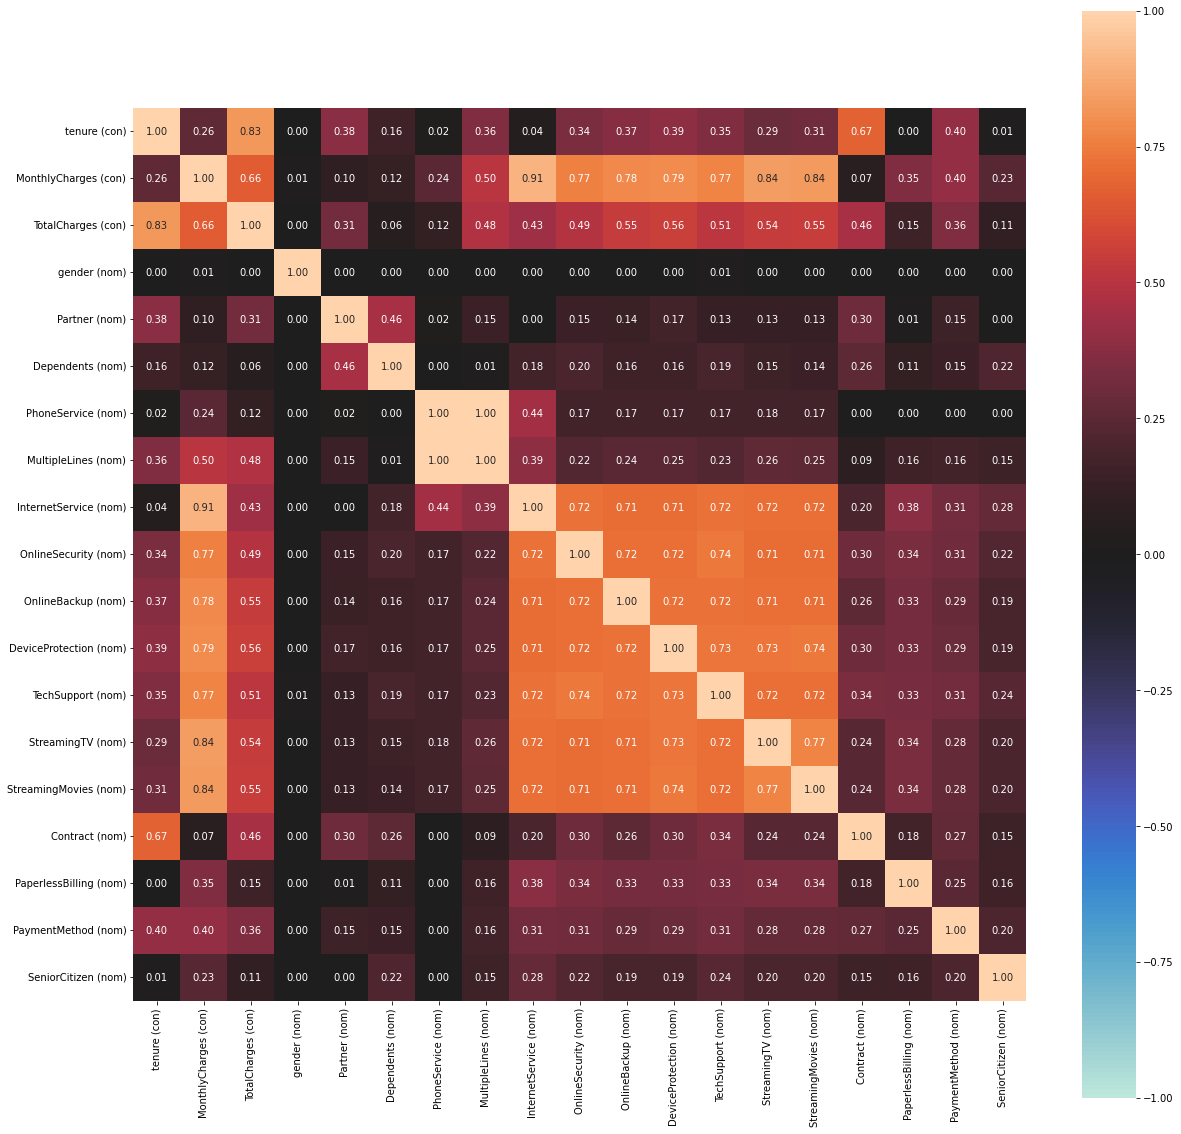

In [120]:
X_train_temp = pd.concat([X_train_num,X_train_cat],axis=1) #merge train set temporarily
ax = associations(X_train_temp, numerical_columns=num_cols, figsize=(20,20), fmt='.2f',annot=True, clustering=False, mark_columns=True)

Since the correlation matrix barely changes, we can use the relevant features from EDA as follows:

Categorical
- `gender`
- `SeniorCitizen`
- `Partner`
- `Dependents`
- `Contract`
- `PaperlessBilling`
- `PaymentMethod`
- `MultipleLines`
- `InternetService`

Numerical
- `tenure`
- `MonthlyCharges`

Redefine num_cols and cat_cols.

In [121]:
num_cols = ['tenure'] + ['MonthlyCharges']
cat_cols = ['gender'] + ['SeniorCitizen'] + ['Partner'] + ['Dependents'] + ['Contract'] + ['PaperlessBilling'] + ['PaymentMethod'] + ['MultipleLines'] + ['InternetService']

#### 5.5.2. Feature Scaling

Since the model approaches logistic regression, we will use `StandardScaler` to scale the numerical features.

In [122]:
#scaling
stdscaler = StandardScaler()

#### 5.5.2. Feature Encoding

Before we proceed to feature encoding, let's check the unique values of each categorical features.

In [123]:
X_train_temp[cat_cols].nunique().sort_values()

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
PaperlessBilling    2
Contract            3
MultipleLines       3
InternetService     3
PaymentMethod       4
dtype: int64

Most of the features have only two unique values. We will divide the method for encoding as follows:
- For features with only two unique values, we will use Ordinal Encoder to maintain current dimensionality
- For `Contract`, we will also use Ordinal Encoder with artificial ordinality based on EDA, the higher the chance of churn, the higher the ordinality and thus we have the ordinality from lowest to highest as `Two year`, `One year`, and `Month-to-month`
- For `MultipleLines`, we will also use Ordinal Encoder with artifical ordinality from lowest to highest `No phone service`, `No`, `Yes`
- For `InternetService`, we will also use Ordinal Encoder with artifical ordinality from lowest to highest `No`, `DSL`, `Fiber optic`
- For `PaymentMethod`, we will use One Hot Encoding

In [124]:
ohe = OneHotEncoder()
oe = OrdinalEncoder()
contract_oe = OrdinalEncoder(categories=[['Two year','One year','Month-to-month']])
line_oe = OrdinalEncoder(categories=[['No phone service','No','Yes']])
internet_oe = OrdinalEncoder(categories=[['No','DSL','Fiber optic']])

### 5.6. Preprocessing Pipeline

Create a pipeline to preprocess the data.

In [125]:
prepline = ColumnTransformer([
    ('scaler', stdscaler, num_cols),
    ('oe', oe, ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']),
    ('contract_oe', contract_oe, ['Contract']),
    ('line_oe', line_oe, ['MultipleLines']),
    ('internet_oe', internet_oe, ['InternetService']),
    ('ohe', ohe, ['PaymentMethod'])
], remainder='drop')

Save the preprocessing pipeline for deployment.

In [389]:
# with open('prepline.pkl', 'wb') as f:
#     pickle.dump(prepline, f)

Transform the dataset.

In [127]:
X_train_final = prepline.fit_transform(X_train_temp)
X_val_final = prepline.fit_transform(X_val)
X_test_final = prepline.fit_transform(X_test)

Check the shape for model input.

In [128]:
X_train_final.shape

(5070, 14)

### 5.7. Tensorflow Input Pipeline

Create an input pipeline for tensorflow model. We will create dataset from slices of the input and then separate them into batches.

In [129]:
train_set = tf.data.Dataset.from_tensor_slices((X_train_final, y_train))
train_set = train_set.batch(int(X_train_final.shape[0]/10))

val_set = tf.data.Dataset.from_tensor_slices((X_val_final, y_val))
val_set = val_set.batch(int(X_val_final.shape[0]/10))

test_set = tf.data.Dataset.from_tensor_slices((X_test_final, y_test))
test_set = test_set.batch(int(X_test_final.shape[0]/10))

## 6. Model Definition

The model used will be defined in two separate ways: sequential API and functional API. However, both will have the same amount of layer, same number of hidden neurons, and same parameters that serve as the baseline models.

Define the baseline parameter.

In [130]:
optimizer = 'adam'
metrics = ['accuracy']

### 6.1. Sequential API

Define sequential model.

In [131]:
#sequential model
seq_model = Sequential()
seq_model.add(Dense(10, activation='relu', input_shape=(14,)))
seq_model.add(Dense(1, activation='sigmoid'))

#compile
seq_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=metrics)

seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                150       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


### 6.2. Functional API

Define functional model.

In [132]:
#functional model
in_func = Input(shape=(14,))
h1_func = Dense(10, activation='relu')(in_func)
out_func = Dense(1, activation='sigmoid')(h1_func)

#combine
func_model = Model(inputs=in_func, outputs=out_func)

#compile
func_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=metrics)

func_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_6 (Dense)             (None, 10)                150       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


## 7. Model Training

Train the models and save the loss and accuracy from each epoch.

Sequential

In [133]:
seq_history = seq_model.fit(train_set, epochs=100, validation_data=val_set, verbose=0)

seq_metrics = pd.DataFrame(seq_history.history)

Functional

In [134]:
#train
func_history = func_model.fit(train_set, epochs=100, validation_data=val_set, verbose=0)

func_metrics = pd.DataFrame(func_history.history)

## 8. Model Evaluation

### 8.1. Baseline Model Evaluation

Let's plot the loss and accuracy of the model first to get a better grasp. We will start with sequential model.

Make a general function for plotting first.

In [138]:
def plot_loss_acc(dataframe):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(dataframe.index, dataframe['loss'], label='train')
    plt.plot(dataframe.index, dataframe['val_loss'], label='validation')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(dataframe.index, dataframe['accuracy'], label='train')
    plt.plot(dataframe.index, dataframe['val_accuracy'], label='validation')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

Plot the loss and accuracy of the model.

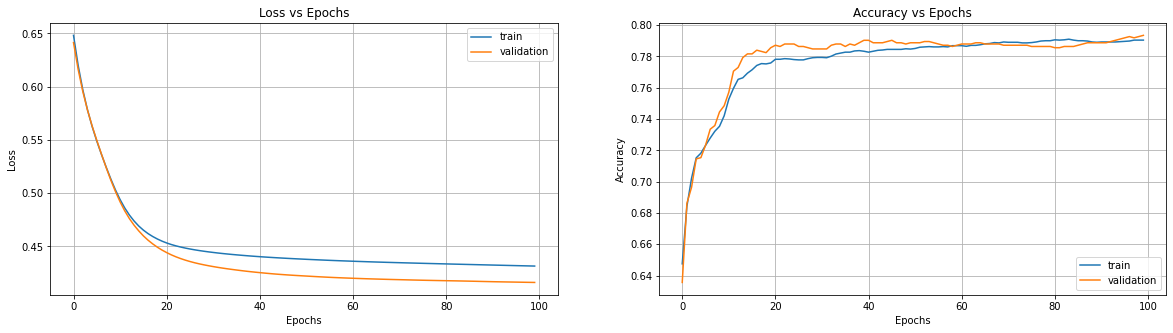

In [139]:
plot_loss_acc(seq_metrics)

In [140]:
seq_model.evaluate(train_set)

10/10 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.7905


[0.4314731955528259, 0.7905325293540955]

Here we see that the sequential loss will form a parallel line after 50 epochs and further epochs will probably still result in parallel line which is fine and we can consider this a good fit to the validation set. The baseline model is already good enough but we will try to improve it later. Let's check the classification report of the model.

Train

In [141]:
y_train_pred = seq_model.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3725
           1       0.63      0.50      0.56      1345

    accuracy                           0.79      5070
   macro avg       0.73      0.70      0.71      5070
weighted avg       0.78      0.79      0.78      5070



Test

In [142]:
y_test_pred = seq_model.predict(test_set)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       518
           1       0.63      0.51      0.56       187

    accuracy                           0.79       705
   macro avg       0.73      0.70      0.71       705
weighted avg       0.78      0.79      0.78       705



We see that the precision and recall for class 1 is lower compared to class 0 in both train and test set. This is very likely due to imbalance in class support. The model itself already performs well seeing the f1 weighted score is very close (train 0.79 vs test 0.79).

Next we will check the result of functional model training.

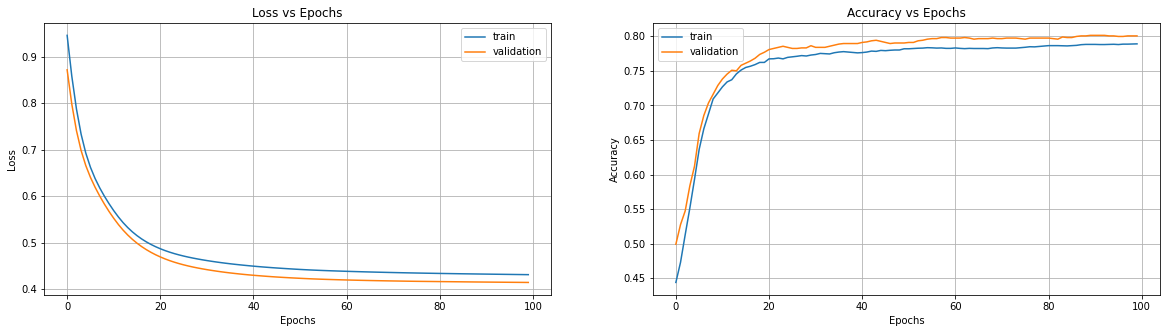

In [143]:
plot_loss_acc(func_metrics)

In [144]:
func_model.evaluate(train_set)

10/10 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7886


[0.4306631088256836, 0.788560152053833]

The functional model performs similarly. **This might change if we rerun the model a few times due to the poor reproducibility of tensorflow model despite setting global seed.**

### 8.2. Model Improvement

Now we will try to improve the baseline model. Our baseline model managed to reach 0.79 accuracy so the goal for improvement is to get a better accuracy and/or lower loss.

#### Adding Hidden Layer(s)

Let's try adding two more layers and see whether the accuracy on train set improved or not.

Let's add some layers to the model and see the change.

In [145]:
# Model Declaration
model_impro = Sequential([
    Dense(10, activation='relu', input_shape=(14,)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model
model_impro.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Train Sequential Method
model_metrics = model_impro.fit(train_set, epochs=100, validation_data=val_set, verbose=0)
model_metrics = pd.DataFrame(model_metrics.history)

print(model_impro.evaluate(train_set))

10/10 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.8030
[0.42085129022598267, 0.802958607673645]


Compare the result with the baseline model.

In [146]:
seq_model.evaluate(train_set)

10/10 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.7905


[0.4314731955528259, 0.7905325293540955]

It looks like we get slightly lower loss and slightly higher accuracy. Adding even more layers may or may not improve the model. Since the input node is already small as it is, we should maintain the current hidden layers and try other methods.

Plot the loss and accuracy of the model.

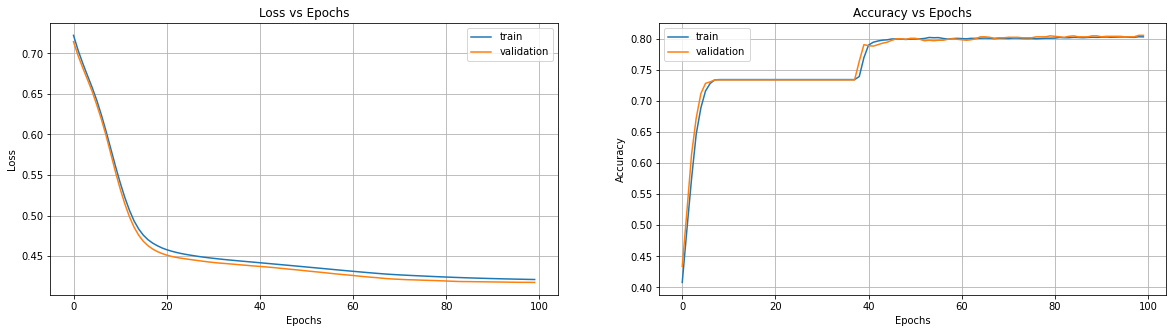

In [147]:
plot_loss_acc(model_metrics)

The model losses will likely converge at further epochs.

Now compare the classification report to check the performance on class 1 prediction.

Baseline

In [148]:
y_train_pred = seq_model.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3725
           1       0.63      0.50      0.56      1345

    accuracy                           0.79      5070
   macro avg       0.73      0.70      0.71      5070
weighted avg       0.78      0.79      0.78      5070



Improved

In [149]:
y_train_pred = model_impro.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3725
           1       0.65      0.55      0.60      1345

    accuracy                           0.80      5070
   macro avg       0.75      0.72      0.73      5070
weighted avg       0.79      0.80      0.80      5070



The improved model has higher precision on class 1 and slightly higher recall on class 0 so we can say that the improved model is indeed an improvement not just in name.

#### Class Weighting

Earlier we know that the support is imbalanced. Instead of artificially creating dataspots using SMOTE, we will try to add class weighting to the model.

See the following reference for more details:
[https://www.tensorflow.org/tutorials/structured_data/imbalanced_data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

Define the weight first.

In [150]:
#count the support for each class
class_0, class_1 = np.bincount(df['Churn-num'])
total = class_0 + class_1

#calculate the weight 
weight_for_0 = (1 / class_0) * (total / 2.0)
weight_for_1 = (1 / class_1) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


Train the previous model with class weighting.

In [151]:
# Model Declaration
weighted_model = Sequential([
    Dense(10, activation='relu', input_shape=(14,)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model
weighted_model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Train Sequential Method
wtmodel_metrics = weighted_model.fit(train_set, epochs=100, validation_data=val_set, verbose=0, class_weight=class_weight)
wtmodel_metrics = pd.DataFrame(wtmodel_metrics.history)

print(weighted_model.evaluate(train_set))

10/10 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7304
[0.49386441707611084, 0.7303747534751892]


The loss went up and the accuracy went down if we compare it with the improved model.

In [164]:
model_impro.evaluate(train_set)

10/10 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8030


[0.42085129022598267, 0.802958607673645]

Check the loss and accuracy graph of the model.

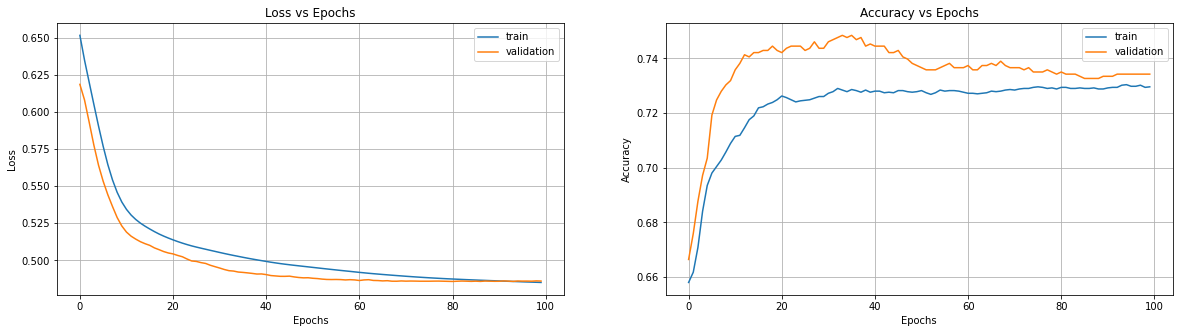

In [153]:
plot_loss_acc(wtmodel_metrics)

Current epoch is good enough.

Let's compare the classification report.

Improved

In [165]:
y_train_pred = model_impro.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3725
           1       0.65      0.55      0.60      1345

    accuracy                           0.80      5070
   macro avg       0.75      0.72      0.73      5070
weighted avg       0.79      0.80      0.80      5070



Class Weighting

In [155]:
y_train_pred = weighted_model.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      3725
           1       0.50      0.82      0.62      1345

    accuracy                           0.73      5070
   macro avg       0.71      0.76      0.70      5070
weighted avg       0.80      0.73      0.75      5070



The recall for class 1 goes up significantly, while the precision went down. As for class 0, the precision increased, while the recall decreased.

Is this a good trade off?

Now let's consider a few things:
- Our primary goal is to predict whether the customer will churn or not
- In the case we detected a retained customer, but the model predicted the customer will churn, it will still be fine because in actual we will not be losing customers
- But in the case we detected a churned customer as retained customer, this will result in actual loss in business opportunity and that's why predicting this point is more important

Based on the points stated above, getting the recall for class 1 at higher value is actually a better option even at the cost of accuracy.

#### Adding Batch Normalization

Let's try adding batch normalization to the model.

In [359]:
# Model Declaration
bn_model = Sequential([
    Dense(10, activation='relu', input_shape=(14,)),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model
bn_model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Train Sequential Method
bn_metrics = bn_model.fit(train_set, epochs=100, validation_data=val_set, verbose=0, class_weight=class_weight)
bn_metrics = pd.DataFrame(bn_metrics.history)

print(bn_model.evaluate(train_set))

10/10 [==============================] - 0s 1ms/step - loss: 0.4890 - accuracy: 0.7495
[0.4889623820781708, 0.7495068907737732]


Accuracy increased, while loss decreased.

There is slight decrease in class 1 recall but we see significant increase to class 1 precision and class 0 recall. Good trade off.

Check the metrics.

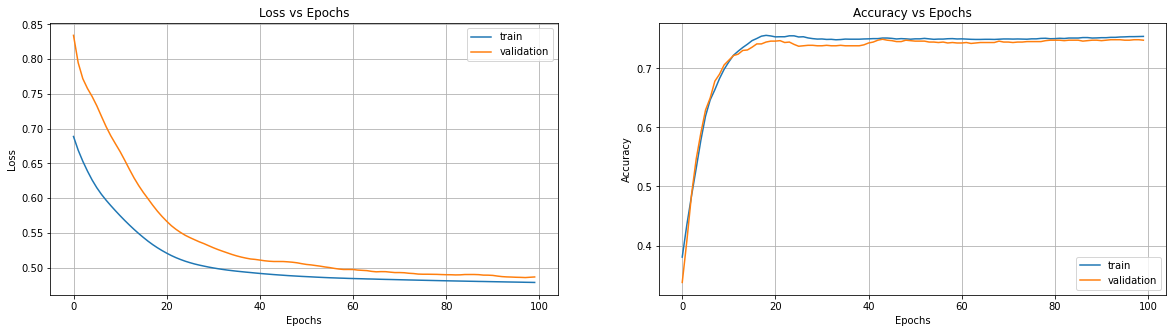

In [360]:
plot_loss_acc(bn_metrics)

The loss will probably converged at a little more than 100 epochs. Recheck the classification report for train and test set against class weighted model.

Class Weighted Train

In [361]:
y_train_pred = weighted_model.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      3725
           1       0.50      0.82      0.62      1345

    accuracy                           0.73      5070
   macro avg       0.71      0.76      0.70      5070
weighted avg       0.80      0.73      0.75      5070



Train

In [362]:
y_train_pred = bn_model.predict(train_set)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3725
           1       0.52      0.82      0.64      1345

    accuracy                           0.75      5070
   macro avg       0.72      0.77      0.72      5070
weighted avg       0.81      0.75      0.76      5070



The current model managed to increase the recall for class 0 and precision for class 1 compared to the class weighted model.

Test

In [363]:
y_test_pred = bn_model.predict(test_set)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81       518
           1       0.53      0.83      0.64       187

    accuracy                           0.76       705
   macro avg       0.72      0.78      0.73       705
weighted avg       0.82      0.76      0.77       705



The model fit perfectly between train and test set. We will use this model for the final submission. 

### 8.3. Model Saving

Save the model.

In [379]:
# bn_model.save('tensormodel.h5') #disabled to prevent overwriting the best model

### 8.4. Model Explainability

Define column names for dataframe after preprocessing.

In [365]:
final_cols = [
    'tenure',
    'MonthlyCharges', 
    'gender', 
    'SeniorCitizen',
    'Partner',
    'Dpendents',
    'PaperlessBilling',
    'Contract',
    'MultipleLines',
    'InternetService',
    'PaymentMethod: Bank transfer (automatic)',
    'PaymentMethod: Credit card (automatic)',
    'PaymentMethod: Electronic check',
    'PaymentMethod: Mailed check'
]

Change transformed by prepline to dataframe.

In [366]:
df_train_final = pd.DataFrame(X_train_final, columns=final_cols)

Use dalex explainer to check model feature importance.

In [372]:
explainer = dx.Explainer(bn_model, df_train_final, y_train, label='Churn')

Preparation of a new explainer is initiated

  -> data              : 5070 rows 14 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5070 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : Churn
  -> predict function  : <function yhat_tf_regression at 0x000001C19FB931C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00644, mean = 0.418, max = 0.951
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.929, mean = -0.153, max = 0.987
  -> model_info        : package keras

A new explainer has been created!


Plot the feature importance.

In [378]:
explainer.model_parts().plot()

Looks like `tenure` affect the outcome significantly compared to other features, followed by `Contract`, and `InternetService`, while the rest of the features have less impact.

In [388]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

## 9. Model Inference

Do an inference using the model that have been developed. Create an entry for prediction.

In [367]:
inference = pd.DataFrame({
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'Contract': 'One year',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MultipleLines': 'No phone service',
    'InternetService': 'Fiber optic',
    'tenure': '12',
    'MonthlyCharges': '50'
}, index=[0])

Transform the dataset using the same preprocessing pipeline.

In [368]:
inf_trans = prepline.transform(inference)

Load the model.

In [369]:
from tensorflow.keras.models import load_model
saved_model = load_model('tensormodel.h5')

Predict the result.

In [370]:
inf_pred = saved_model.predict(inf_trans)
inf_pred = np.where(inf_pred > 0.5, 'Churned', 'Remained')
print(inf_pred)

[['Churned']]


The customer churned.

## 10. Conclusion

Based on the analysis and modeling that have been done, we can conclude the followings:

1. The target is imbalanced with ratio roughly 3:1 for customer who stayed against customer who churned
2. Features that are fully independent for each numerical and categorical category (low correlation) will be used for model training. Those features are:

    Categorical
    - `gender`
    - `SeniorCitizen`
    - `Partner`
    - `Dependents`
    - `Contract`
    - `PaperlessBilling`
    - `PaymentMethod`
    - `MultipleLines`
    - `InternetService`

    Numerical
    - `tenure`
    - `MonthlyCharges`
3. The baseline models already performed good enough, but need some improvement to better predict class 1 due to imbalance support
4. The model is improved by adding additional layers, class weighting, and batch normalization which results in higher recall for class 1. This means the model can better predict which customer will churn and avoid false negatives
5. The model is mostly affected by `tenure`, followed by `Contract` and `InternetService`